In [1]:
import pandas as pd
import numpy as np

import scanpy as sc

import seaborn as sns
import matplotlib.pyplot as plt
colors = ['#FF6666', '#33C7CC', '#0F0A26', '#425266', '#F7F5FF']
sns.set_palette(sns.color_palette(colors))

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

from tqdm import tqdm

### Read data

In [2]:
### target
target = pd.read_csv('../data/vcc_de_signature.csv', index_col=0)
### we set the self expression to zero, as it is the cause and not the consequence of perturbation
for gene in target.index:
    target.loc[gene, gene] = 0.0

In [3]:
### de features
features_de = pd.read_parquet("../data/all_de_noself_pca.parquet")

In [5]:
counts_train = pd.read_csv('../data/cell_counts.csv', index_col=0)
counts_train.drop('non-targeting', inplace=True)
counts_test = pd.read_csv('../data/pert_counts_Test.csv', index_col=0)
counts_test = counts_test[['n_cells']]
counts_test.columns = counts_train.columns
features_count = np.log1p(pd.concat([counts_train, counts_test], axis=0))

Text(0, 0.5, 'density')

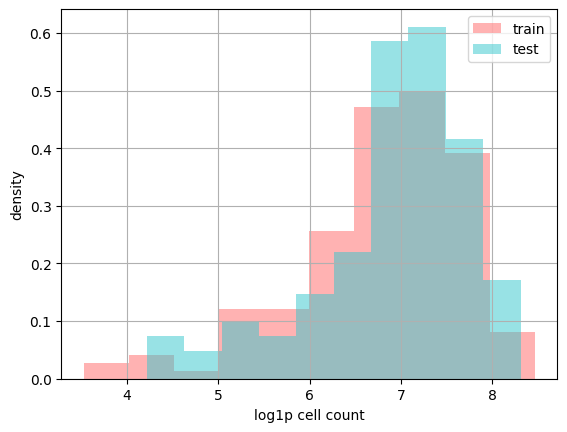

In [6]:
### count distribution is reasonable similar for train and test
np.log1p(counts_train['count']).hist(density=True, alpha=0.5, label='train')
np.log1p(counts_test['count']).hist(density=True, alpha=0.5, label='test')
plt.legend()
plt.xlabel('log1p cell count')
plt.ylabel('density')

In [7]:
train_genes = list(counts_train.index)
test_genes = list(counts_test.index)
assert len(train_genes) == 150
assert len(test_genes) == 100

### Train / Predict model

In [8]:
X = pd.concat(
    [
        features_de.loc[train_genes + test_genes],
        features_count.loc[train_genes + test_genes],
    ],
    axis=1,
)
Y = target.loc[train_genes]

In [9]:
model = Ridge(alpha=0.4)
np.random.seed(20220602) # just to make it fully reproducible
model.fit(X.loc[train_genes], Y)
Y_pred_de = pd.DataFrame(
    model.predict(X.loc[test_genes]),
    index=test_genes,
    columns=Y.columns,
)

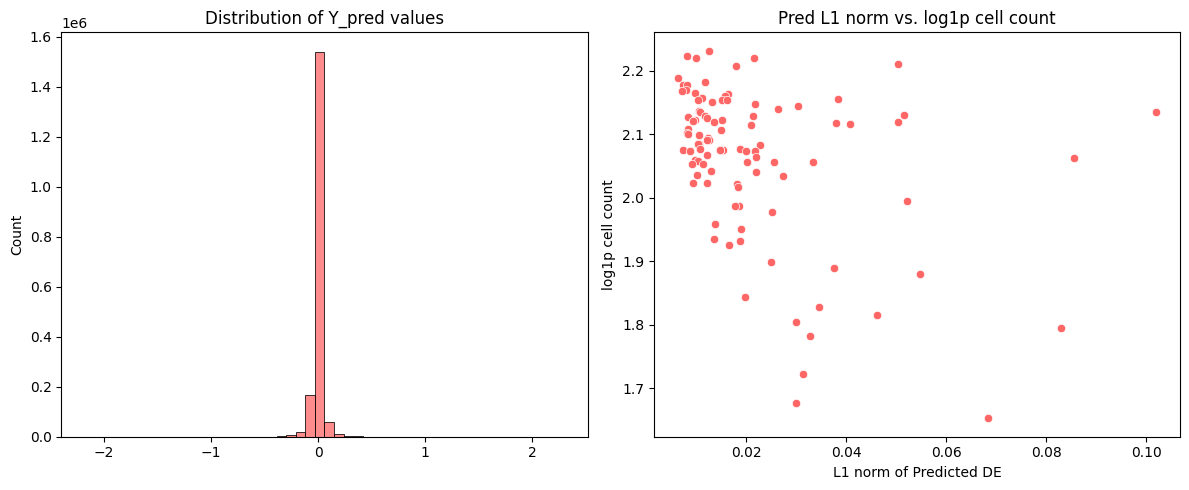

In [10]:
### sanity checks regarding predicted distibution and L1-norm - count relatipnship
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(Y_pred_de.values.flatten(), bins=50, ax=axes[0])
axes[0].set_title('Distribution of Y_pred values')

sns.scatterplot(x=Y_pred_de.abs().mean(1), y=np.log1p(features_count.loc[test_genes, 'count']), ax=axes[1])
axes[1].set_xlabel('L1 norm of Predicted DE')
axes[1].set_ylabel('log1p cell count')
axes[1].set_title('Pred L1 norm vs. log1p cell count')

plt.tight_layout()

In [11]:
### scaling
Y_pred_de_scaled = Y_pred_de.copy()

th = 0.01
w = 8

fil = Y_pred_de_scaled.abs().mean(1) > th
Y_pred_de_scaled.loc[fil] = Y_pred_de_scaled.loc[fil] * w

In [12]:
### setting target gene expression to low
for gene in Y_pred_de_scaled.index:
    Y_pred_de_scaled.loc[gene, gene] = Y_pred_de_scaled.loc[gene].min()

In [13]:
### adding control
CTRL = 7.5
Y_pred = Y_pred_de_scaled + CTRL
### preds must be >0 and < 15
Y_pred[Y_pred < 0] = 0.0
Y_pred[Y_pred >= 15] = 14.99
Y_pred.loc['non-targeting'] = 7.5

In [14]:
Y_pred.to_csv('../results/pseudobulk.csv')

### Create submission

In [15]:
adata_example = sc.read_h5ad('../data/vcc_1000_ctrl.h5ad')

In [16]:
counts_train = pd.read_csv('../data/cell_counts.csv', index_col=0)
counts_test = pd.read_csv('../data/pert_counts_Test.csv', index_col=0)
counts_test = counts_test[['n_cells']]
counts_test.columns = counts_train.columns

In [17]:
total_counts = counts_test['count'].sum() + counts_train['count']['non-targeting']

In [18]:
new_obs = pd.DataFrame(index=[str(x) for x in range(total_counts)], columns=adata_example.obs.columns)
new_var = adata_example.var.copy()
target_genes = []
for gene in counts_test.index:
    target_genes += [gene] * counts_test.loc[gene, 'count']
while len(target_genes) < total_counts:
    target_genes += ['non-targeting']
new_obs['target_gene'] = target_genes
new_obs['guide_id'] = target_genes ### just the gene name as guid id
new_obs['batch'] = "Flex_1_01" ### reusing somehting from the train dataset

In [19]:
new_X_array = np.zeros(shape=(total_counts, Y_pred.shape[1]))
for i in tqdm(range(total_counts)):
    new_X_array[i, :] = Y_pred.loc[new_obs.loc[str(i), "target_gene"]].values
adata_new = sc.AnnData(X=new_X_array, obs=new_obs, var=new_var)
adata_new.write_h5ad('../results/vcc_final_submission.h5ad')

100%|██████████| 170846/170846 [00:08<00:00, 19663.73it/s]
